In [1]:
import numpy as np
import matplotlib.pyplot as plt
from quake.models.qsvm import genetic_v3 as genetic
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from collections import OrderedDict
from qiskit.circuit import ParameterVector
from qiskit.circuit import QuantumCircuit
import pandas as pd
import csv

In [3]:
suffix = '2023_12_29 -00_00_11'
df = pd.read_csv("../../Output_genetic/"+suffix+"/genes" +
                 suffix+".csv", header=None, index_col=False)
# df_kernels = pd.read_csv("../../Output_genetic/"+suffix +
#                          "/kernels_flattened"+suffix+".csv", header=None, index_col=False)
accuracies = np.loadtxt("../../Output_genetic/" +
                        suffix+"/accuracy"+suffix+".txt")
sparsities = np.loadtxt("../../Output_genetic/" +
                        suffix+"/sparsity"+suffix+".txt")
df_fitnesses = pd.read_csv("../../Output_genetic/"+suffix +
                       "/fitness_values_iter_"+suffix+".csv", header=None, index_col=False)

fitnesses = df_fitnesses.to_numpy()[:, 0]
n_epochs = 50
keep_elitism = 2
pop_size = 10

In [4]:
# Regroup fitness and other metrics values in generations
grouped_fitness = np.zeros((n_epochs + 1, pop_size))
grouped_sparsity = np.zeros((n_epochs + 1, pop_size))
grouped_accuracy = np.zeros((n_epochs + 1, pop_size))
grouped_fitness[0] = fitnesses[:pop_size]
grouped_sparsity[0] = sparsities[:pop_size]  # init generation
grouped_accuracy[0] = accuracies[:pop_size]
for i in range(n_epochs):
    counter = (pop_size - keep_elitism)*i
    best_old_idxs = np.argsort(grouped_fitness[i])[-keep_elitism:]
    grouped_sparsity[i+1] = np.concatenate([grouped_sparsity[i][best_old_idxs],
                                           sparsities[counter + pop_size: 2*pop_size + counter - keep_elitism]])
    grouped_accuracy[i+1] = np.concatenate([grouped_accuracy[i][best_old_idxs],
                                           accuracies[counter + pop_size: 2*pop_size + counter - keep_elitism]])
    grouped_fitness[i+1] = np.concatenate([grouped_fitness[i][best_old_idxs],
                                          fitnesses[pop_size + counter: 2*pop_size + counter - keep_elitism]])

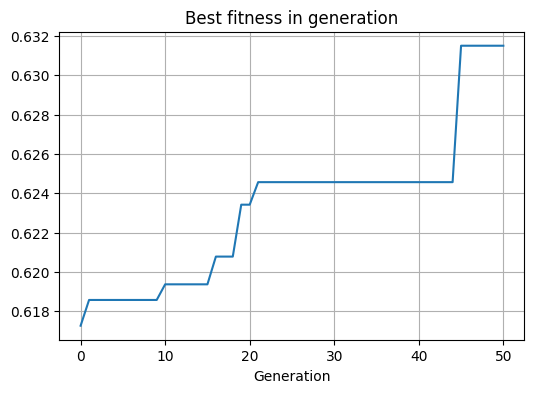

In [5]:
plt.figure(figsize=(6, 4))
plt.plot(np.max(grouped_fitness, axis=1))
plt.xlabel("Generation")
plt.title("Best fitness in generation")
plt.grid()
# plt.savefig("../../Output_genetic/"+suffix+"/best_fit_generation.svg")

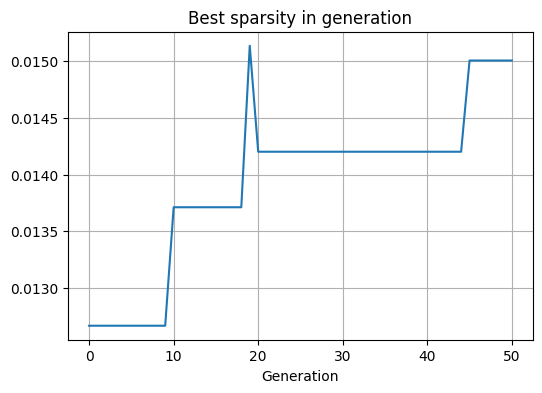

In [6]:
best_sparsities = np.zeros(n_epochs+1)
for i in range(n_epochs+1):
    best_sparsities[i] = np.max(grouped_sparsity[i])

plt.figure(figsize=(6, 4))
plt.plot(best_sparsities)
plt.xlabel("Generation")
plt.title("Best sparsity in generation")
plt.grid()
# plt.savefig("../../Output_genetic/"+suffix+"/best_sparsity_in_generation.svg")

In [8]:
fittest_kernel_id = np.argmax(fitnesses)
fittest_kernel_accuracy = accuracies[fittest_kernel_id]
fittest_kernel_sparsity = sparsities[fittest_kernel_id]
print(f"Best kernel found after {fittest_kernel_id} iterations")
print(f"Best kernel accuracy: {fittest_kernel_accuracy}")
print(f"Best kernel sparsity: {fittest_kernel_sparsity}")

Best kernel found after 364 iterations
Best kernel accuracy: 0.63
Best kernel sparsity: 0.015004354037498335


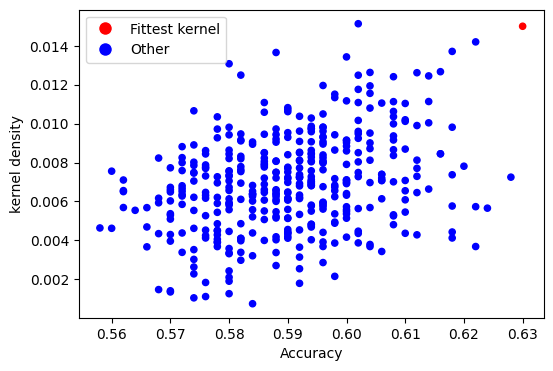

In [9]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(6, 4))
custom_cmap = ListedColormap(['blue', 'red'])
cmap = np.zeros(accuracies.shape[0])
cmap[fittest_kernel_id] = 1
plt.scatter(x=accuracies, y=sparsities, c=cmap, cmap=custom_cmap, s=20)
plt.xlabel("Accuracy")
plt.ylabel("kernel density")
# Create a custom legend
legend_labels = ['Fittest kernel', 'Other']
legend_colors = ['red', 'blue']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[i],
                             markerfacecolor=legend_colors[i], markersize=10) for i in range(len(legend_labels))]
plt.legend(handles=legend_handles)
# plt.savefig("../../Output_genetic/"+suffix+"/accuracy_sparsity_dist.svg")

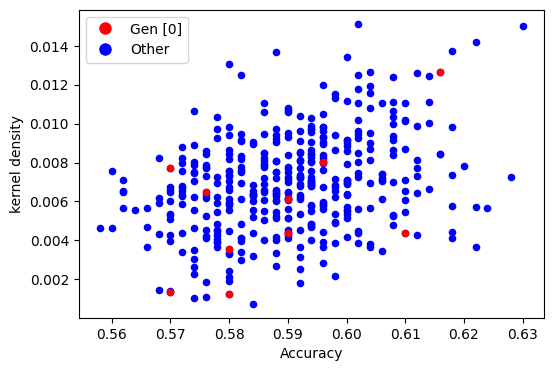

In [11]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(6, 4))
gen_nb = [-1]
plt.scatter(x=accuracies, y=sparsities, c='b', s=20)
plt.scatter(x=grouped_accuracy[gen_nb],
            y=grouped_sparsity[gen_nb], c='r', s=20)

plt.xlabel("Accuracy")
plt.ylabel("kernel density")
# Create a custom legend
legend_labels = [f'Gen {gen_nb}', 'Other']
legend_colors = ['red', 'blue']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[i],
                             markerfacecolor=legend_colors[i], markersize=10) for i in range(len(legend_labels))]
plt.legend(handles=legend_handles)
# plt.savefig("../../Output_genetic/"+suffix+"/gen_best.svg")

In [26]:
genes = df.to_numpy()
NB_QUBITS = 6
GATES_PER_QUBITS = 5
gate_dict = OrderedDict([
    ("single_non_parametric", ["I", "H", "X", "SX"]),
    ("single_parametric", ["RX", "RY", "RZ"]),
    ("two_non_parametric", ["CX"]),
    ("two_parametric", ["CRX", "CRY", "CRZ"]),
])
nb_features = 18
fmap, x_idxs = genetic.to_quantum(
    genes[fittest_kernel_id], gate_dict, nb_features, GATES_PER_QUBITS, NB_QUBITS)
print(np.sort(x_idxs))

[ 0  2  3  5  8  9 10 12 13 14 15 16 17]


In [27]:
features_per_qubit = []
for i in range(accuracies.shape[0]):
    fmap, x_idxs = genetic.to_quantum(
        genes[i], gate_dict, nb_features, GATES_PER_QUBITS, NB_QUBITS)
    features_per_qubit.append(x_idxs)

Text(0.5, 0, 'feature number')

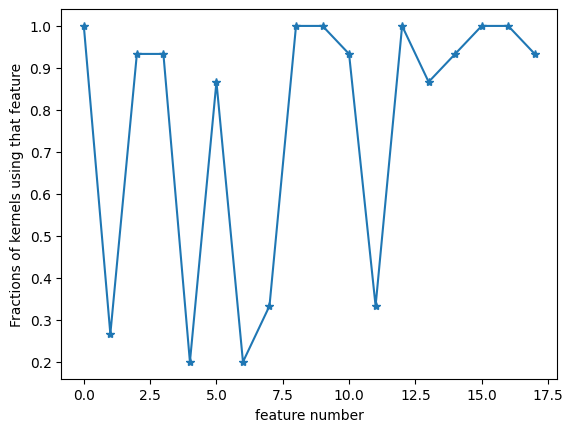

In [28]:
feature_counter = np.zeros(18)
for x_idxs in features_per_qubit[:15]:
    for i in range(18):
        if i in x_idxs:
            feature_counter[i] += 1
plt.plot(np.arange(0, 18), feature_counter / 15, "-*")
plt.ylabel("Fractions of kernels using that feature")
plt.xlabel("feature number")
# plt.savefig("../../Output_genetic/"+suffix+"/feature_repr_0.svg")

Text(0.5, 0, 'feature number')

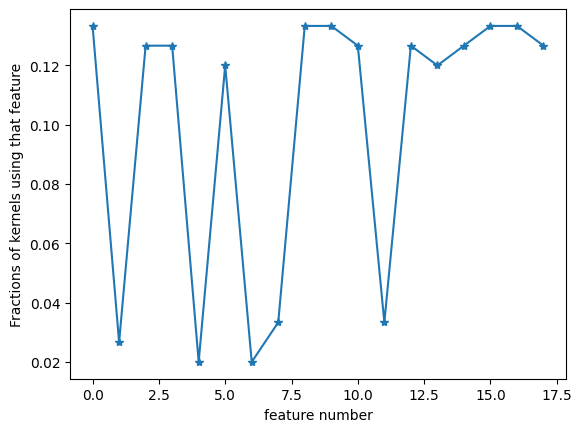

In [29]:
best_kernels_idxs = np.argsort(fitnesses)[-150:]
best_idxs_call_list = np.array(features_per_qubit, dtype='object')[
    best_kernels_idxs]
feature_counter_best = np.zeros(18)
for x_idxs in best_idxs_call_list:
    for i in range(18):
        if i in x_idxs:
            feature_counter_best[i] += 1
plt.plot(np.arange(0, 18), feature_counter_best/150, '-*')
plt.ylabel("Fractions of kernels using that feature")
plt.xlabel("feature number")
# plt.savefig("../../Output_genetic/"+suffix+"/feature_repr_top15.svg")

# Test kernerls
Load the fittest kernel genes, rebuild the quantum featuremap and train

In [30]:
fmap, x_idxs = genetic.to_quantum(
    genes[fittest_kernel_id], gate_dict, nb_features, GATES_PER_QUBITS, NB_QUBITS)
print(np.sort(x_idxs))

[ 0  2  3  5  8  9 10 12 13 14 15 16 17]


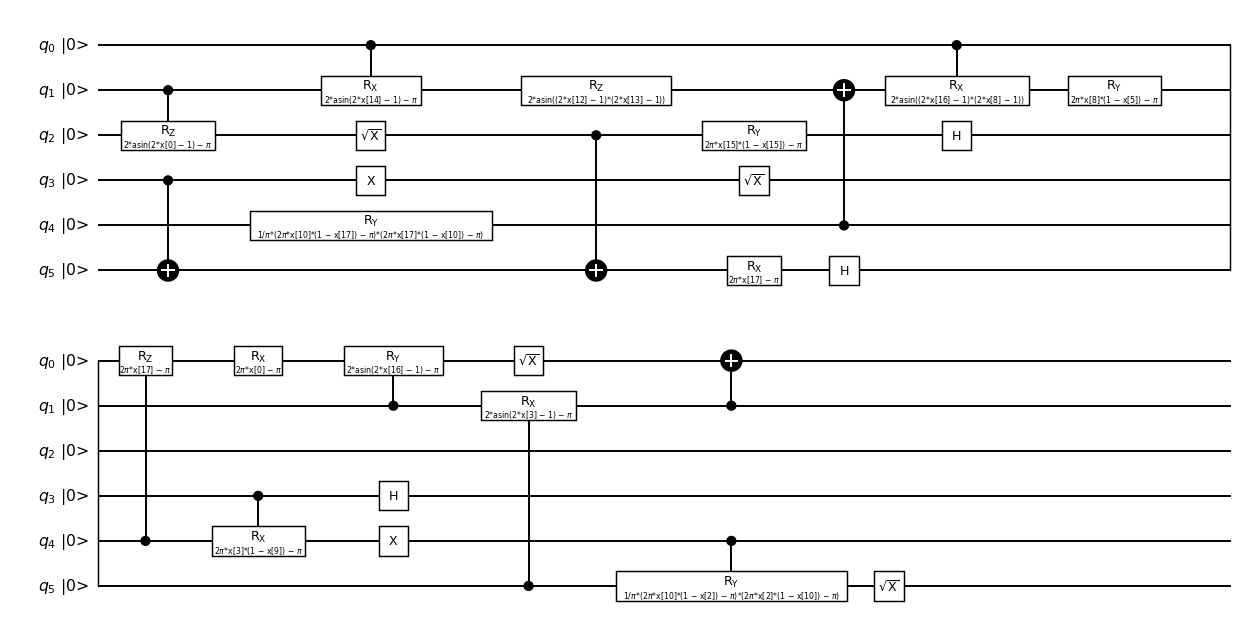

In [31]:
%matplotlib inline
fmap.draw(output='mpl', scale=0.7, initial_state=True, cregbundle=False, style="bw", filename="../../Output_genetic/"+suffix+"/best_kernel_fmap.svg")

In [32]:
from qiskit_machine_learning.kernels import FidelityStatevectorKernel
from quake.utils.utils import load_runcard, save_runcard
from quake.models.autoencoder.autoencoder_dataloading import read_data
from quake.models.autoencoder.train import load_and_compile_network
import numpy as np
from pathlib import Path
from quake.models.qsvm.qsvm_tester import get_features

from quake.models.qsvm import genetic_v3 as genetic

from qiskit import Aer

import time

# Dataset loading
data_folder = Path("../../output_2/data")
train_folder = Path("../../output_2/models/autoencoder")
setup = load_runcard("../../output_2/cards/runcard.yaml")
setup["run_tf_eagerly"] = True
setup["seed"] = 42

dataset, labels = get_features(data_folder.parent, "autoencoder", setup)
scaler = MinMaxScaler((0, 1)).fit(dataset[0])
data_cv, data_labels = genetic.get_subsample(
    dataset[2], labels[2], 500, scaler=scaler)
nb_features = data_cv.shape[1]

nb_features = data_cv.shape[1]
backend = Aer.get_backend("statevector_simulator")

[INFO] (quake.autoencoder) Loading splitting maps from folder: ..\..\output_2\models\autoencoder
INFO:quake.autoencoder:Loading splitting maps from folder: ..\..\output_2\models\autoencoder
[INFO] (quake.autoencoder) Train dataset balancing: 125517 training points, of which 50.12% positives
INFO:quake.autoencoder:Train dataset balancing: 125517 training points, of which 50.12% positives
[INFO] (quake.autoencoder) Validation dataset balancing: 26897 training points, of which 49.77% positives
INFO:quake.autoencoder:Validation dataset balancing: 26897 training points, of which 49.77% positives
[INFO] (quake.autoencoder) Test dataset balancing: 26897 training points, of which 49.74% positives
INFO:quake.autoencoder:Test dataset balancing: 26897 training points, of which 49.74% positives



[INFO] (quake.autoencoder) Loading weights at ..\..\output_2\models\autoencoder\autoencoder.h5
INFO:quake.autoencoder:Loading weights at ..\..\output_2\models\autoencoder\autoencoder.h5


897/897 [==============================] - 4s 4ms/step


(array([80., 68., 41., 33., 11.,  9.,  1.,  7.,  1.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.        , 0.04      , 0.08      , 0.12      , 0.16      ,
        0.2       , 0.23999999, 0.28      , 0.31999999, 0.36000001,
        0.40000001, 0.44      , 0.47999999, 0.51999998, 0.56      ,
        0.60000002, 0.63999999, 0.68000001, 0.72000003, 0.75999999,
        0.80000001, 0.83999997, 0.88      , 0.92000002, 0.95999998,
        1.        ]),
 [<matplotlib.patches.Polygon at 0x225a259ea90>])

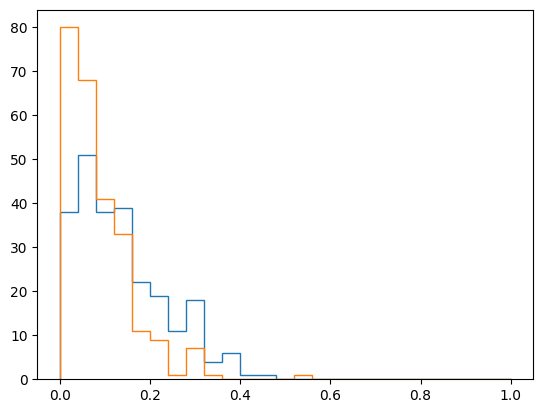

In [33]:
plt.hist(data_cv[data_labels == 0, 15], range=[0, 1], bins=25, histtype='step')
plt.hist(data_cv[data_labels == 1, 15], range=[0, 1], bins=25, histtype='step')

In [34]:
from qiskit_machine_learning.kernels import QuantumKernel

qker = QuantumKernel(feature_map=fmap, quantum_instance=backend)
qker_matrix = qker.evaluate(x_vec=data_cv[:, x_idxs])


clf = SVC(kernel="precomputed")

param_grid = {"C": [0.01, 0.1, 1, 10, 100, 1000, 10000]}
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy")
grid_search.fit(qker_matrix, data_labels)
best_clf = grid_search.best_estimator_
accuracy_cv = cross_val_score(
    best_clf, qker_matrix, data_labels, cv=5, scoring="accuracy"
)
print(best_clf)
print(accuracy_cv.mean())

SVC(C=10, kernel='precomputed')
0.5700000000000001


In [38]:
# Performance on a different, preliminar test set, simply by changing the seed in get_subsample(). Some overlap with the set training set could still occurr!
# Note: We train the model again.
data_test, data_labels_test = genetic.get_subsample(
    dataset[2], labels[2], 500, scaler=scaler, seed=1234)

qker_test = qker.evaluate(x_vec=data_test[:, x_idxs])

param_grid = {"C": [0.01, 0.1, 1, 10, 100, 1000, 10000]}
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy")
grid_search.fit(qker_test, data_labels_test)
best_clf_test = grid_search.best_estimator_
accuracy_test = cross_val_score(
    best_clf_test, qker_test, data_labels_test, cv=5, scoring="accuracy"
)
print(best_clf)
print(accuracy_test.mean())